In [1]:
import os 
import numpy as np
from icecream import ic
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/optim"

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [3]:
import urllib.request
# from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial4/"
# Files to download
pretrained_files = ["FashionMNIST_SGD.config",    "FashionMNIST_SGD_results.json",    "FashionMNIST_SGD.tar",
                    "FashionMNIST_SGDMom.config", "FashionMNIST_SGDMom_results.json", "FashionMNIST_SGDMom.tar",
                    "FashionMNIST_Adam.config",   "FashionMNIST_Adam_results.json",   "FashionMNIST_Adam.tar"   ]
os.makedirs(CHECKPOINT_PATH, exist_ok=True)
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name) 
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        ic('downloading the file....')
        urllib.request.urlretrieve(file_url, file_path)



In [4]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.2861, ), (0.3530, ))])
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform)
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])
train_dataloader = torch.utils.data.DataLoader(dataset=train_set, batch_size=1024, shuffle=True, drop_last=False)
val_dataloader = torch.utils.data.DataLoader(dataset=val_set, batch_size=1024, shuffle=True, drop_last=False)
test_dataloader = torch.utils.data.DataLoader(dataset=test_set, batch_size=1024, shuffle=True, drop_last=False)

In [5]:
imgs, labels = next(iter(test_dataloader))
imgs.requires_grad

False

In [6]:
(train_dataset.data.float()/255.0).mean().item(), (train_dataset.data.float()/255.0).std().item()

(0.28604060411453247, 0.3530242443084717)

In [7]:
imgs, labels = next(iter(train_dataloader))
imgs.shape, imgs.mean(), imgs.std()

(torch.Size([1024, 1, 28, 28]), tensor(0.0017), tensor(0.9994))

In [8]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        super().__init__()
        layers = []
        layers_size = [input_size] + hidden_sizes 
        for layer_idx in range(1, len(layers_size)):
            layers +=  [nn.Linear(layers_size[layer_idx-1], layers_size[layer_idx]), act_fn]
        layers+= [nn.Linear(layers_size[-1], num_classes)]
        # ic(layers)
        self.layers = nn.ModuleList(layers) 
        self.config = {'act_fn':{'name':act_fn}, 'input_size':input_size, 'num_classes':num_classes, 'hidden_sizes':hidden_sizes}

    # def forward(self, x):                           
    #     x = x.view(x.shape[0], -1)
    #     x = self.layers(x)
    #     return x 

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x


In [9]:
bn = BaseNetwork(nn.ReLU())
bn.layers

ModuleList(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=128, bias=True)
  (7): ReLU()
  (8): Linear(in_features=128, out_features=10, bias=True)
)

In [10]:
class Identity(nn.Module):
    def forward(self, x):
        return x

In [11]:
act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "identity": Identity
}

In [12]:
def plot_dists(val_dict, color='C0', xlabel=None, stat='count', use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index%columns]
        sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat, kde=use_kde and ((val_dict[key].max()-val_dict[key].min()>1e-8)))
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig

In [13]:
def visualize_activation(net):
    net.eval()
    # for name, param in net.named_parameters(): 
    #     if 'weight' not in name: 
    #         ic(name)
    ic.disable()      
    activations = {}
    imgs, labels = next(iter(test_dataloader))
    imgs, labels = imgs.to(device), labels.to(device)
    imgs = imgs.view(imgs.shape[0], -1)
    ic(imgs.shape, labels.shape)
    ic(imgs.requires_grad, labels.requires_grad)    
    for layer_idx, layer in enumerate(net.layers[:-1]):
        ic(layer_idx, layer)
        with torch.no_grad():
            imgs = layer(imgs)
            ic(imgs.shape, labels.shape)
            if isinstance(layer, nn.Linear):
                activations[layer_idx] = imgs.view(-1).detach().cpu().numpy()
    fig = plot_dists(activations, stat='density', xlabel='Activation')
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()
    # variance
    ic.enable()
    # this is for variance in activation
    for key in activations.keys():
        ic(key, np.var(activations[key]))


In [14]:
def visualize_grad(net):
    net.eval()
    gradients = {}
    # optim = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    # loss_module = nn.CrossEntropyLoss()
    imgs, labels = next(iter(train_dataloader))
    imgs, labels = imgs.to(device), labels.to(device)
    imgs = imgs.view(imgs.shape[0], -1)
    # optim.zero_grad()
    net.zero_grad()
    preds = net(imgs)
    ic(preds.shape, labels.shape)       
    # preds = torch.argmax(preds, dim=-1)
    ic(preds.shape, labels.shape)
    loss = F.cross_entropy(preds, labels)
    loss.backward()

    # for name, param in net.named_parameters():
    grad = {name:param.grad.view(-1).detach().cpu().numpy() for name, param in net.named_parameters() if 'weight' in name}
    # gradients = 
    fig = plot_dists(grad, stat='density', xlabel='Gradients')
    fig.suptitle("Gradients distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    for key in sorted(grad.keys()):
        print(f"{key} - Variance: {np.var(grad[key])}")

ic| preds.shape: torch.Size([1024, 10])
    labels.shape: torch.Size([1024])
ic| preds.shape: torch.Size([1024, 10])
    labels.shape: torch.Size([1024])


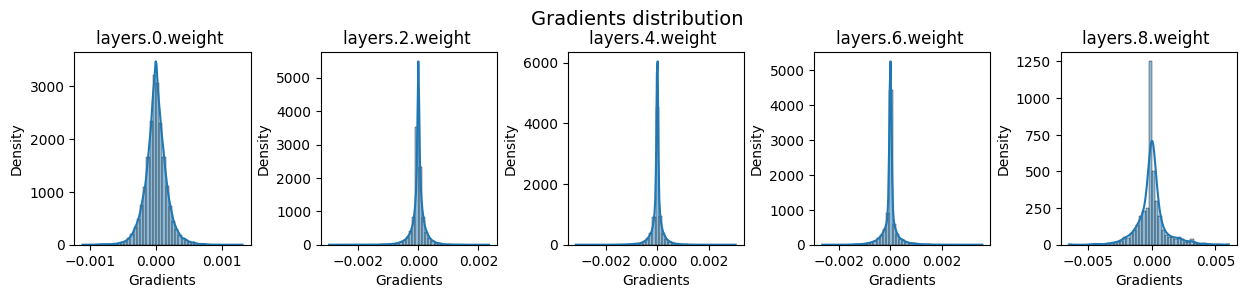

layers.0.weight - Variance: 2.8629576931393785e-08
layers.2.weight - Variance: 5.254859303249759e-08
layers.4.weight - Variance: 5.6055803554500017e-08
layers.6.weight - Variance: 9.25373910831695e-08
layers.8.weight - Variance: 1.2843186141253682e-06


In [15]:
bn_relu = BaseNetwork(nn.ReLU()).to(device)
visualize_grad(bn_relu)     

In [16]:
def const_init(net, w=0.0):
    for name, param in net.named_parameters():
        param.data.fill_(w) 

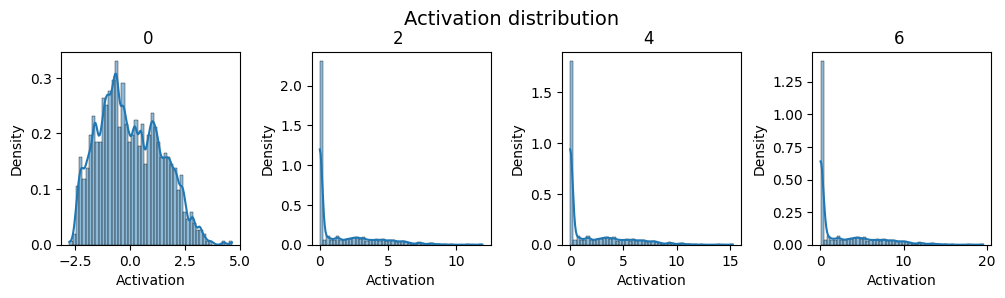

ic| key: 0, np.var(activations[key]): 1.9762044
ic| key: 2, np.var(activations[key]): 4.9149632
ic| key: 4, np.var(activations[key]): 8.052675
ic| key: 6, np.var(activations[key]): 13.193502


In [17]:
bn_relu = BaseNetwork(nn.ReLU()).to(device)
# visualize_activation(bn)
bn_identity = BaseNetwork(Identity()).to(device)
# visualize_activation(bn_identity)
const_init(bn_relu, w=0.005)
# const_init(bn_identity, w=0.005)
# visualize_activation(bn_identity)
visualize_activation(bn_relu)

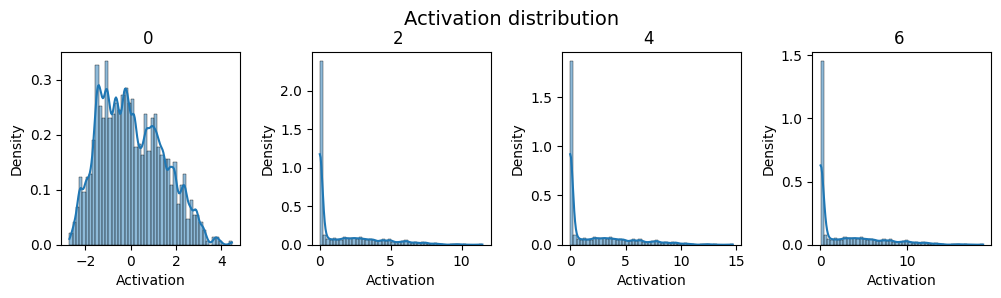

ic| key: 0, np.var(activations[key]): 1.9342672
ic| key: 2, np.var(activations[key]): 5.086529
ic| key: 4, np.var(activations[key]): 8.333769
ic| key: 6, np.var(activations[key]): 13.654039
ic| preds.shape: torch.Size([1024, 10])
    labels.shape: torch.Size([1024])
ic| preds.shape: torch.Size([1024, 10])
    labels.shape: torch.Size([1024])


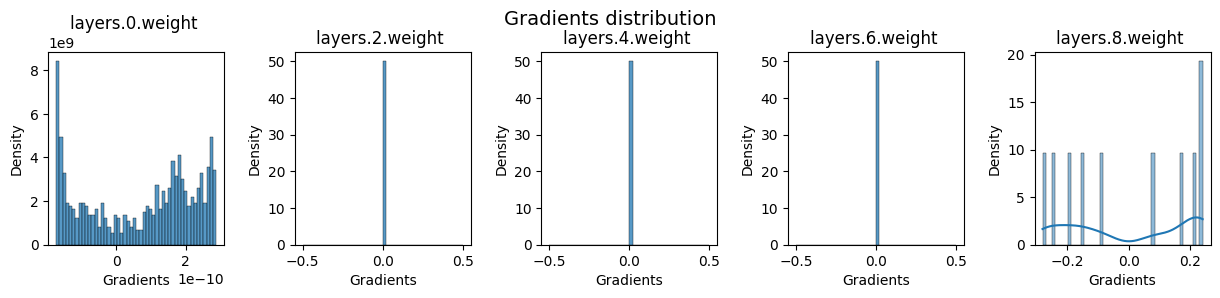

layers.0.weight - Variance: 2.4458588493089366e-20
layers.2.weight - Variance: 4.8148248609680896e-33
layers.4.weight - Variance: 1.232595164407831e-32
layers.6.weight - Variance: 0.0
layers.8.weight - Variance: 0.03994186967611313


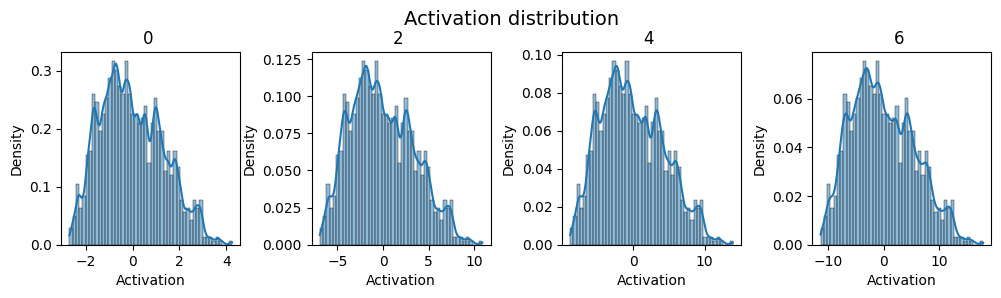

ic| key: 0, np.var(activations[key]): 1.8064356
ic| key: 2, np.var(activations[key]): 11.838657
ic| key: 4, np.var(activations[key]): 19.396458
ic| key: 6, np.var(activations[key]): 31.77915
ic| preds.shape: torch.Size([1024, 10])
    labels.shape: torch.Size([1024])
ic| preds.shape: torch.Size([1024, 10])
    labels.shape: torch.Size([1024])


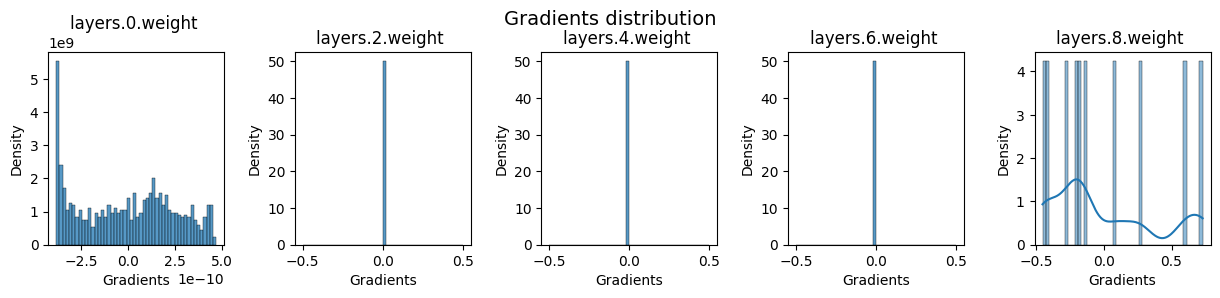

layers.0.weight - Variance: 6.48036750199226e-20
layers.2.weight - Variance: 4.81482486096809e-35
layers.4.weight - Variance: 1.0833355937178202e-34
layers.6.weight - Variance: 4.81482486096809e-35
layers.8.weight - Variance: 0.15280713140964508


In [18]:
bn_relu = BaseNetwork(nn.ReLU()).to(device)
bn_identity = BaseNetwork(Identity()).to(device)
const_init(bn_relu, w=0.005)
const_init(bn_identity, w=0.005)
visualize_activation(bn_relu)
visualize_grad(bn_relu)
visualize_activation(bn_identity)
visualize_grad(bn_identity)




In [19]:
# 1/dx 
import math
def equal_var_init(net):
    for name, param in net.named_parameters():
        ic(name, param.shape)
        if 'bias' in name:
            param.data.fill_(0.0)
        elif 'weight' in name:
            # param.data.normal_(std=(math.sqrt(1/param.shape[1])))
            variance = 1/param.shape[1]
            b = math.sqrt(3 * variance)
            a = -b
            param.data.uniform_(a, b)

ic| name: 'layers.0.weight', param.shape: torch.Size([512, 784])
ic| name: 'layers.0.bias', param.shape: torch.Size([512])
ic| name: 'layers.2.weight', param.shape: torch.Size([256, 512])
ic| name: 'layers.2.bias', param.shape: torch.Size([256])
ic| name: 'layers.4.weight', param.shape: torch.Size([256, 256])
ic| name: 'layers.4.bias', param.shape: torch.Size([256])
ic| name: 'layers.6.weight', param.shape: torch.Size([128, 256])
ic| name: 'layers.6.bias', param.shape: torch.Size([128])
ic| name: 'layers.8.weight', param.shape: torch.Size([10, 128])
ic| name: 'layers.8.bias', param.shape: torch.Size([10])
ic| preds.shape: torch.Size([1024, 10])
    labels.shape: torch.Size([1024])
ic

| preds.shape: torch.Size([1024, 10])
    labels.shape: torch.Size([1024])


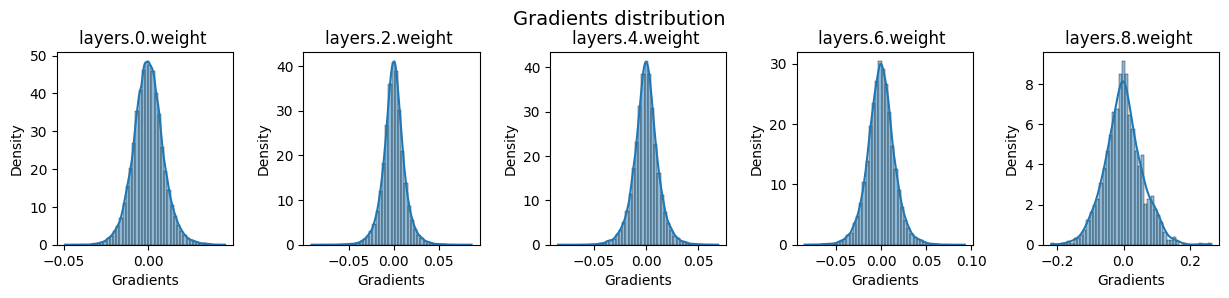

layers.0.weight - Variance: 7.924417877802625e-05
layers.2.weight - Variance: 0.00014703348278999329
layers.4.weight - Variance: 0.0001391293917549774
layers.6.weight - Variance: 0.00023317728482652456
layers.8.weight - Variance: 0.003150974167510867


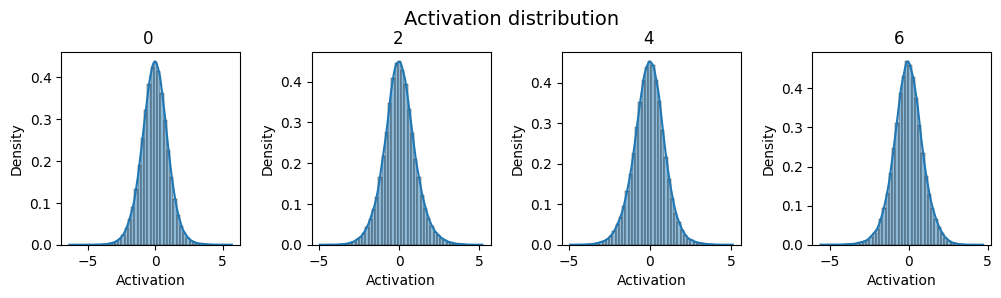

ic| key: 0, np.var(activations[key]): 0.9423875
ic| key: 2, np.var(activations[key]): 0.9546249
ic| key: 4, np.var(activations[key]): 0.89381766
ic| key: 6, np.var(activations[key]): 0.8643718


In [20]:
bn_relu = BaseNetwork(nn.ReLU()).to(device)
bn_identity = BaseNetwork(Identity()).to(device)
model = bn_identity
equal_var_init(model)
visualize_grad(net=model)
visualize_activation(net=model)


In [21]:
# model and training 
def _get_config_file(model_name):
    return os.path.join(CHECKPOINT_PATH, model_name+'.config')
def _get_model_file(model_name):
    return os.path.join(CHECKPOINT_PATH, model_name+'.tar')

In [22]:

_get_config_file(model_name='FashionMNIST_Adam')

'../saved_models/optim/FashionMNIST_Adam.config'

In [23]:
import json
def _load_model(model_name, net=None):
    config_file, model_file = _get_config_file(model_name), _get_model_file(model_name)
    with open(config_file, 'r') as f:
        config_dict = json.load(f)
    # ic(config_dict)
    # def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
    if net is None:
        act_fn = act_fn_by_name[config_dict.pop('act_fn').lower()]
        net = BaseNetwork(act_fn(), **config_dict)
    net = net.load_state_dict(torch.load(model_file, map_location=device))
    ic(config_dict, net)

In [24]:
_load_model('FashionMNIST_Adam')

ic| config_dict: {'hidden_sizes': [512, 256, 256, 128], 'input_size': 784, 'num_classes': 10}
    net: <All keys matched successfully>


In [25]:
def save_model(model, model_name):
    config_dict = model.config
    os.makedir(CHECKPOINT_PATH, exist_ok=True)
    config_file, model_file = _get_config_file(model_name), _get_model_file(model_name)
    with open(config_file, 'w') as f:
        json.dump(f, config_dict)
    torch.save(model.state_dict(), model_file)

In [26]:
from tqdm import tqdm
def train_model(net, model_name, optim_fn, max_epoch=50, batch_size=256, overwrite=True):
    file_exist = os.path.isfile(CHECKPOINT_PATH+_get_model_file(model_name))
    ic(file_exist)
    if file_exist and not overwrite:
        print(f'skipping training!!')
    else:
        if file_exist:
            print(f'existing model file {model_name} will be overwritten.')
        print(f'starting training .....')
        optim = optim_fn(net.parameters())
        loss_module = nn.CrossEntropyLoss()
        for epoch in range(1, 2):
            net.train()
            for imgs, labels in tqdm(train_dataloader, leave=False):
                imgs, labels = imgs.to(device), labels.to(device)
                ic(imgs.shape)
                imgs = imgs.view(imgs.shape[0], -1)
                ic(imgs.shape)
                optim.zero_grad()
                preds = net(imgs)
                ic(preds.shape)
                loss = loss_module(preds, imgs)
                loss.backward()
                optim.step()
                

        
    


In [27]:
bn = BaseNetwork(act_fn=act_fn_by_name['relu']()).to(device)
train_model(bn, model_name='test', optim_fn="adam")

ic| file_exist: False


starting training .....


  0%|          | 0/49 [00:00<?, ?it/s]ic| imgs.shape: torch.Size([1024, 1, 28, 28])
ic| imgs.shape: torch.Size([1024, 784])
ic| preds.shape: torch.Size([1024, 10])
  2%|▏         | 1/49 [00:00<00:13,  3.68it/s]ic| imgs.shape: torch.Size([1024, 1, 28, 28])
ic| imgs.shape: torch.Size([1024, 784])
ic| preds.shape: torch.Size([1024, 10])
  4%|▍         | 2/49 [00:00<00:12,  3.62it/s]ic| imgs.shape: torch.Size([1024, 1, 28, 28])
ic| imgs.shape: torch.Size([1024, 784])
ic| preds.shape: torch.Size([1024, 10])
  6%|▌         | 3/49 [00:00<00:12,  3.62it/s]ic| imgs.shape: torch.Size([1024, 1, 28, 28])
ic| imgs.shape: torch.Size([1024, 784])
ic| preds.shape: torch.Size([1024, 10])
  8%|▊         | 4/49 [00:01<00:13,  3.40it/s]ic| imgs.shape: torch.Size([1024, 1, 28, 28])
ic| imgs.shape: torch.Size([1024, 784])
ic| preds.shape: torch.Size([1024, 10])
 10%|█         | 5/49 [00:01<00:13,  3.30it/s]

ic| imgs.shape: torch.Size([1024, 1, 28, 28])
ic| imgs.shape: torch.Size([1024, 784])
ic| preds.shape: torch.Size([1024, 10])
 12%|█▏        | 6/49 [00:01<00:12,  3.51it/s]ic| imgs.shape: torch.Size([1024, 1, 28, 28])
ic| imgs.shape: torch.Size([1024, 784])
ic| preds.shape: torch.Size([1024, 10])
 14%|█▍        | 7/49 [00:02<00:12,  3.43it/s]ic| imgs.shape: torch.Size([1024, 1, 28, 28])
ic| imgs.shape: torch.Size([1024, 784])
ic| preds.shape: torch.Size([1024, 10])
 16%|█▋        | 8/49 [00:02<00:11,  3.56it/s]ic| imgs.shape: torch.Size([1024, 1, 28, 28])
ic| imgs.shape: torch.Size([1024, 784])
ic| preds.shape: torch.Size([1024, 10])
 18%|█▊        | 9/49 [00:02<00:11,  3.56it/s]ic| imgs.shape: torch.Size([1024, 1, 28, 28])
ic| imgs.shape: torch.Size([1024, 784])
ic| preds.shape: torch.Size([1024, 10])
 20%|██        | 10/49 [00:02<00:10,  3.63it/s]ic| imgs.shape: torch.Size([1024, 1, 28, 28])
ic| imgs.shape: torch.Size([1024, 784])
ic| preds.shape: torch.Size([1024, 10])
 22%|██▏     

KeyboardInterrupt: 

In [ ]:
        imgs, lab = next(iter(train_dataloader))
        imgs.shape

torch.Size([1024, 1, 28, 28])